In [173]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.sparse import diags

from HybridSuperQubits.jja import JosephsonJunctionArray as JJA
from HybridSuperQubits.jja import NumericalJosephsonJunctionArray as nJJA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
measured_frequencies = np.array(
    [
        4.51958,
        8.09260,
        10.5514,
        12.2285,
        13.4316,
        14.2727,
        14.8896,
        15.3278,
        15.6783,
        15.976,
        16.165,
        16.340,
        16.493,
        16.607,
        16.696,
        # 16.775
    ]
)

mode_indices = np.arange(1, len(measured_frequencies) + 1)
N = 251

# 1. Analytical expression

In [175]:
results = JJA.fit_from_measurements(
    measured_frequencies=measured_frequencies,
    # mode_indices=mode_indices,
    N=N,
)

k = np.linspace(mode_indices[0], mode_indices[-1], 100)
fitted = JJA.analytical_mode_frequencies(**results["parameters"], N=N, k=k)

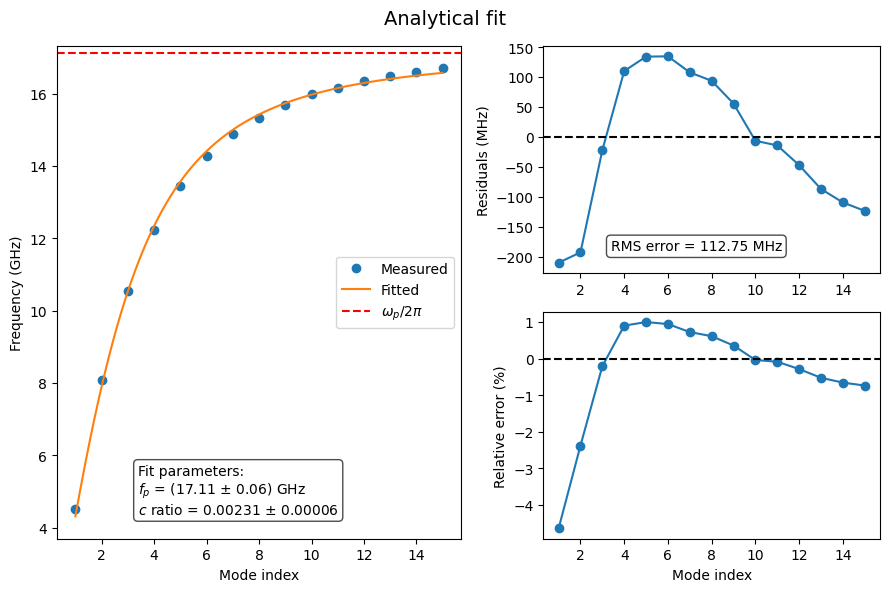

In [177]:
fig = plt.figure(figsize=(9, 6))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1.2, 1])

# Left plot
ax0 = fig.add_subplot(gs[:, 0])
ax0.plot(mode_indices, measured_frequencies, "o", label="Measured")
ax0.plot(k, fitted, "-", label="Fitted")
ax0.axhline(
    results["parameters"]["f_p"], color="red", linestyle="--", label=r"$\omega_p/2\pi$"
)
ax0.set_ylabel("Frequency (GHz)")
ax0.set_xlabel("Mode index")
ax0.legend()

# Add text with fit parameters
f_p = results["parameters"]["f_p"]
c_ratio = results["parameters"]["c_ratio"]
f_p_err = results["uncertainties"]["f_p"]
c_ratio_err = results["uncertainties"]["c_ratio"]

param_text = (
    f"Fit parameters:\n"
    f"$f_p$ = ({f_p:.2f} ± {f_p_err:.2f}) GHz\n"
    f"$c$ ratio = {c_ratio:.5f} ± {c_ratio_err:.5f}"
)
ax0.text(
    0.2,
    0.05,
    param_text,
    transform=ax0.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

# Top right plot
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(mode_indices, results["errors"]["residuals"] * 1e3, "o-")
ax1.set_ylabel("Residuals (MHz)")
ax1.axhline(0, color="black", linestyle="--")

# Bottom right plot
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax2.plot(mode_indices, results["errors"]["relative_error_percent"], "o-")
ax2.set_ylabel("Relative error (%)")
ax2.set_xlabel("Mode index")
ax2.axhline(0, color="black", linestyle="--")

# Add RMS error info
rms_error = results["errors"]["rms_error"]
error_text = f"RMS error = {rms_error * 1e3:.2f} MHz"
ax1.text(
    0.2,
    0.1,
    error_text,
    transform=ax1.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

fig.suptitle("Analytical fit", fontsize=14)
fig.tight_layout()
plt.show()

# 2. Numerical expression

## 2.1. Simplest model

In [214]:
def default_C_matrix(jja: nJJA) -> np.ndarray:
    N = jja.N
    Cjj = jja.Cj
    Cg = jja.Cg
    diagonals = [
        (-Cjj) * np.ones(N - 2),
        (2 * Cjj + Cg) * np.ones(N - 1),
        (-Cjj) * np.ones(N - 2),
    ]

    matrix = diags(diagonals, offsets=[-1, 0, 1]).toarray()
    return matrix


def default_L_inv_matrix(jja: nJJA) -> np.ndarray:
    N = jja.N
    Lj = jja.Lj
    diagonals = [
        (-1 / Lj) * np.ones(N - 2),
        (2 / Lj) * np.ones(N - 1),
        (-1 / Lj) * np.ones(N - 2),
    ]
    return diags(diagonals, offsets=[-1, 0, 1]).toarray()


bounds = [
    [0.5, 10.0, 20.0],
    [4.0, 50.0, 100.0],
]

fitted_jja, results = nJJA.fit_from_measurements(
    measured_frequencies=measured_frequencies,
    N=251,
    build_C_matrix_fn=default_C_matrix,
    build_L_inv_matrix_fn=default_L_inv_matrix,
    bounds=bounds,
    relative_error=False,
)

Fit summary:
Parameters: [ 2.02466173 42.73706475 98.87255981]
Cost: 0.094753138282067
Message: `xtol` termination condition is satisfied.


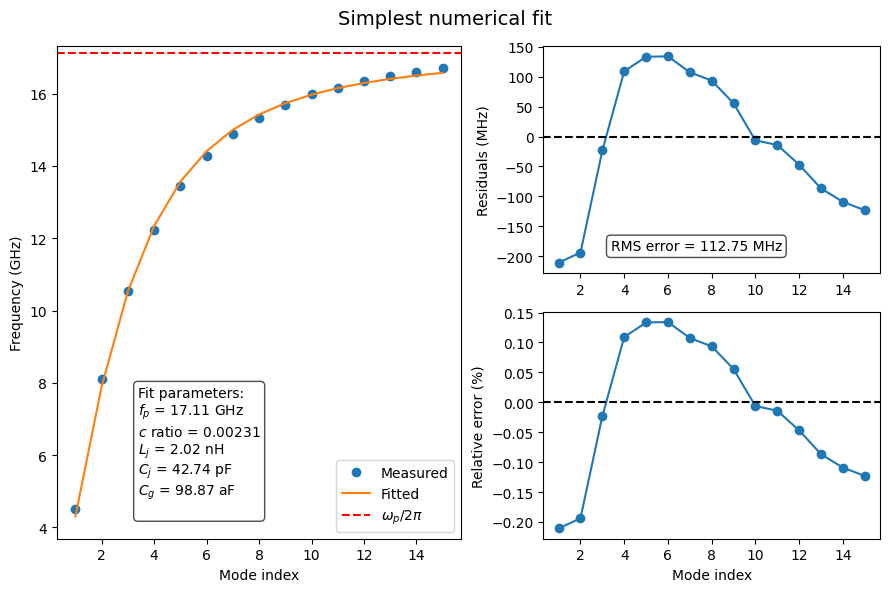

In [215]:
fig = plt.figure(figsize=(9, 6))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1.2, 1])
ax0 = fig.add_subplot(gs[:, 0])

ax0.plot(mode_indices, measured_frequencies, "o", label="Measured")
ax0.plot(
    mode_indices,
    fitted_jja.resonance_frequencies()[: len(measured_frequencies)],
    "-",
    label="Fitted",
)
ax0.axhline(
    fitted_jja.plasma_frequency, color="red", linestyle="--", label=r"$\omega_p/2\pi$"
)
ax0.set_ylabel("Frequency (GHz)")
ax0.set_xlabel("Mode index")
ax0.legend()
# Add text with fit parameters
f_p = fitted_jja.plasma_frequency
c_ratio = fitted_jja.C_ratio
Lj = fitted_jja.Lj * 1e9
Cj = fitted_jja.Cj * 1e15
Cg = fitted_jja.Cg * 1e18

param_text = (
    f"Fit parameters:\n"
    f"$f_p$ = {f_p:.2f} GHz\n"
    f"$c$ ratio = {c_ratio:.5f}\n"
    f"$L_j$ = {Lj:.2f} nH\n"
    f"$C_j$ = {Cj:.2f} pF\n"
    f"$C_g$ = {Cg:.2f} aF\n"
)
ax0.text(
    0.2,
    0.05,
    param_text,
    transform=ax0.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

# Top right plot
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(mode_indices, results["residuals"] * 1e3, "o-")
ax1.set_ylabel("Residuals (MHz)")
ax1.axhline(0, color="black", linestyle="--")

# Bottom right plot
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax2.plot(mode_indices, results["residuals"], "o-")
ax2.set_ylabel("Relative error (%)")
ax2.set_xlabel("Mode index")
ax2.axhline(0, color="black", linestyle="--")

# Add RMS error info
rms_error = results["errors"]["rmse"] * 1e3
error_text = f"RMS error = {rms_error:.2f} MHz"
ax1.text(
    0.2,
    0.1,
    error_text,
    transform=ax1.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

fig.suptitle("Simplest numerical fit", fontsize=14)
fig.tight_layout()
plt.show()

## 2.2. Includying $C_{in}$

In [191]:
def C_matrix_with_Cin(jja: nJJA) -> np.ndarray:
    N = jja.N
    Cjj = jja.Cj
    Cg = jja.Cg
    Cin = jja.extra_params.get("Cin", 0.0)

    diagonals = [
        (-Cjj) * np.ones(N - 2),
        (2 * Cjj + Cg) * np.ones(N - 1),
        (-Cjj) * np.ones(N - 2),
    ]
    C = diags(diagonals, [-1, 0, 1]).toarray()
    C[0, 0] += Cin
    return C


def build_extra_params(p_extra: list[float]) -> dict[str, float]:
    return {
        "Cin": p_extra[0] * 1e-15,  # fF → F
    }

In [192]:
initial_params = [2.0, 42.0, 98.0, 10]  # Lj, Cj, Cg, Cin, Cout
bounds = ([0.5, 10.0, 10.0, 0.0], [3.0, 50.0, 100.0, 50.0])

fitted_jja, results = nJJA.fit_from_measurements(
    measured_frequencies=measured_frequencies,
    N=251,
    build_C_matrix_fn=C_matrix_with_Cin,
    build_L_inv_matrix_fn=default_L_inv_matrix,
    initial_params=initial_params,
    bounds=bounds,
    relative_error=False,
    verbose=True,
    extra_param_names=["Cin"],
    build_extra_params_fn=build_extra_params,
)

Fit summary:
Parameters: [ 2.08821291 40.44391249 95.87450392 14.76484065]
Cost: 0.10081166161240795
Message: `ftol` termination condition is satisfied.


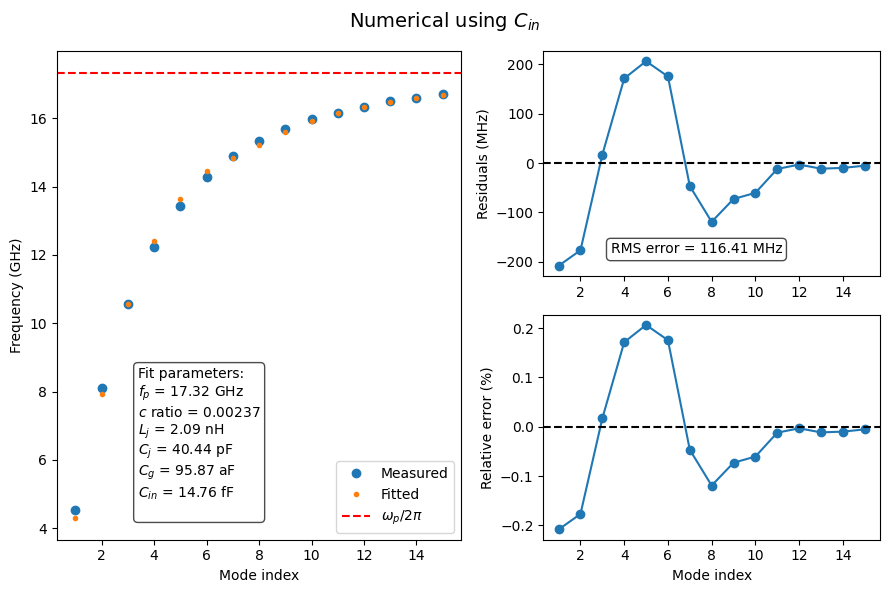

In [ ]:
fig = plt.figure(figsize=(9, 6))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1.2, 1])
ax0 = fig.add_subplot(gs[:, 0])

ax0.plot(mode_indices, measured_frequencies, "o", label="Measured")
ax0.plot(
    mode_indices,
    fitted_jja.resonance_frequencies()[: len(measured_frequencies)],
    ".",
    label="Fitted",
)
ax0.axhline(
    fitted_jja.plasma_frequency, color="red", linestyle="--", label=r"$\omega_p/2\pi$"
)
ax0.set_ylabel("Frequency (GHz)")
ax0.set_xlabel("Mode index")
ax0.legend()
# Add text with fit parameters
Lj = fitted_jja.Lj * 1e9
Cj = fitted_jja.Cj * 1e15
Cg = fitted_jja.Cg * 1e18
C_in = fitted_jja.extra_params["Cin"] * 1e15  # Convert to fF

param_text = (
    f"Fit parameters:\n"
    f"$f_p$ = {fitted_jja.plasma_frequency:.2f} GHz\n"
    f"$c$ ratio = {fitted_jja.C_ratio:.5f}\n"
    f"$L_j$ = {Lj:.2f} nH\n"
    f"$C_j$ = {Cj:.2f} pF\n"
    f"$C_g$ = {Cg:.2f} aF\n"
    f"$C_{{in}}$ = {C_in:.2f} fF\n"
)
ax0.text(
    0.2,
    0.05,
    param_text,
    transform=ax0.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

# Top right plot
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(mode_indices, results["residuals"] * 1e3, "o-")
ax1.set_ylabel("Residuals (MHz)")
ax1.axhline(0, color="black", linestyle="--")

# Bottom right plot
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax2.plot(mode_indices, results["residuals"], "o-")
ax2.set_ylabel("Relative error (%)")
ax2.set_xlabel("Mode index")
ax2.axhline(0, color="black", linestyle="--")

# Add RMS error info
rms_error = results["errors"]["rmse"] * 1e3
error_text = f"RMS error = {rms_error:.2f} MHz"
ax1.text(
    0.2,
    0.1,
    error_text,
    transform=ax1.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

fig.suptitle(r"Numerical using $C_{in}$", fontsize=14)
fig.tight_layout()
plt.show()

## 2.3. Long distance Coulomb interaction

In [183]:
def compute_capacitance_matrix(N, epsilon, a, a0, d, max_terms=1000):
    """
    Computes the capacitance matrix C_g^{-1}(n, m) based on the analytical
    expression for the potential V_n in terms of charges Q̃_m.

    Parameters
    ----------
    N : int
        Total number of nodes. The resulting matrix will have shape (N-1, N-1).
    epsilon : float
        Relative permittivity (ε).
    a : float
        Lateral spacing between elements (multiplies (n - m)).
    a0 : float
        Characteristic offset or regularization length scale.
    d : float
        Vertical spacing (used in the series expansion term).
    max_terms : int, optional
        Number of terms to keep in the infinite series (default is 1000).

    Returns
    -------
    Cg : np.ndarray
        Capacitance matrix C_g^{-1} of shape (N-1, N-1).

    Notes
    -----
    The formula implemented is:

        (C_g^{-1})_{n,m} = (1 / (2π ε₀ (1 + ε))) *
                           [ 1 / sqrt((n - m)^2 a^2 + a₀^2)
                             - Σ_{j=1..∞} (2 ε (1 - ε)^{j - 1} / (1 + ε)^j )
                               / sqrt((n - m)^2 a^2 + (2 j d)^2) ]
    """
    from scipy.constants import epsilon_0

    # Generate node indices from 1 to N-1
    n_indices = np.arange(1, N)
    m_indices = np.arange(1, N)

    # Compute (n - m) for each matrix element (shape: (N-1, N-1))
    delta_nm = n_indices[:, None] - m_indices[None, :]

    # First term: 1 / sqrt((n - m)^2 * a^2 + a0^2)
    term1 = 1.0 / np.sqrt(delta_nm**2 * a**2 + a0**2)

    # Series terms: j = 1 to max_terms
    j = np.arange(1, max_terms + 1)

    # Precompute the scalar coefficients for each j
    # Compute series factors using logarithmic identities to avoid overflow
    with np.errstate(over="ignore", divide="ignore"):
        log_series = (
            np.log(2 * epsilon)
            + (j - 1) * np.log(np.abs(1 - epsilon))
            - j * np.log(1 + epsilon)
        )
        sign_correction = np.sign(1 - epsilon) ** (j - 1)
        series_factors = sign_correction * np.exp(log_series)

    # Compute the denominator for each (n, m, j): sqrt((n - m)^2 * a^2 + (2jd)^2)
    jd_squared = (2 * j * d) ** 2  # shape: (max_terms,)
    denom_series = np.sqrt(
        delta_nm[None, :, :] ** 2 * a**2 + jd_squared[:, None, None]
    )  # shape: (max_terms, N-1, N-1)

    # Compute the summation over j
    term2 = np.sum(
        series_factors[:, None, None] / denom_series, axis=0
    )  # shape: (N-1, N-1)

    # Combine both terms
    inverse_matrix = term1 - term2

    # Apply the constant prefactor
    prefactor = 1.0 / (2 * np.pi * epsilon_0 * (1 + epsilon))
    C_inv = prefactor * inverse_matrix

    Cg = np.linalg.inv(C_inv)

    return Cg

In [184]:
C_g_long_distance = compute_capacitance_matrix(
    N=251, epsilon=11.6, a=0.645e-6, a0=0.6e-6, d=850e-6, max_terms=1000
)
C_g_long_distance
# Verifica que no haya nans
np.isnan(C_g_long_distance).any()

np.False_

In [194]:
def C_matrix_long_distance(jja: nJJA) -> np.ndarray:
    Cj = jja.Cj
    diagonals = [
        (-Cj) * np.ones(N - 2),
        (2 * Cj) * np.ones(N - 1),
        (-Cj) * np.ones(N - 2),
    ]
    C = diags(diagonals, [-1, 0, 1]).toarray()

    a0 = jja.extra_params.get("a0", 0.645e-6)

    C_g_long_distance = compute_capacitance_matrix(
        N=jja.N, epsilon=11.6, a=0.645e-6, a0=a0, d=850e-6, max_terms=1000
    )

    C += C_g_long_distance
    return C


def build_extra_params(p_extra: list[float]) -> dict[str, float]:
    return {
        "a0": p_extra[0] * 1e-6,  # µm → m
    }

In [195]:
initial_params = [2, 42.0, 98.0, 0.6]  # Lj, Cj, Cg, a0
bounds = ([1, 10.0, 10.0, 0], [5.0, 50.0, 100.0, 2])

fitted_jja, results = nJJA.fit_from_measurements(
    measured_frequencies=measured_frequencies,
    N=251,
    build_C_matrix_fn=C_matrix_long_distance,
    build_L_inv_matrix_fn=default_L_inv_matrix,
    initial_params=initial_params,
    bounds=bounds,
    relative_error=False,
    verbose=True,
    extra_param_names=["a0"],
    build_extra_params_fn=build_extra_params,
)

Fit summary:
Parameters: [ 3.02136965 25.04902151 98.04253745  0.95277737]
Cost: 0.15504109979878278
Message: `ftol` termination condition is satisfied.


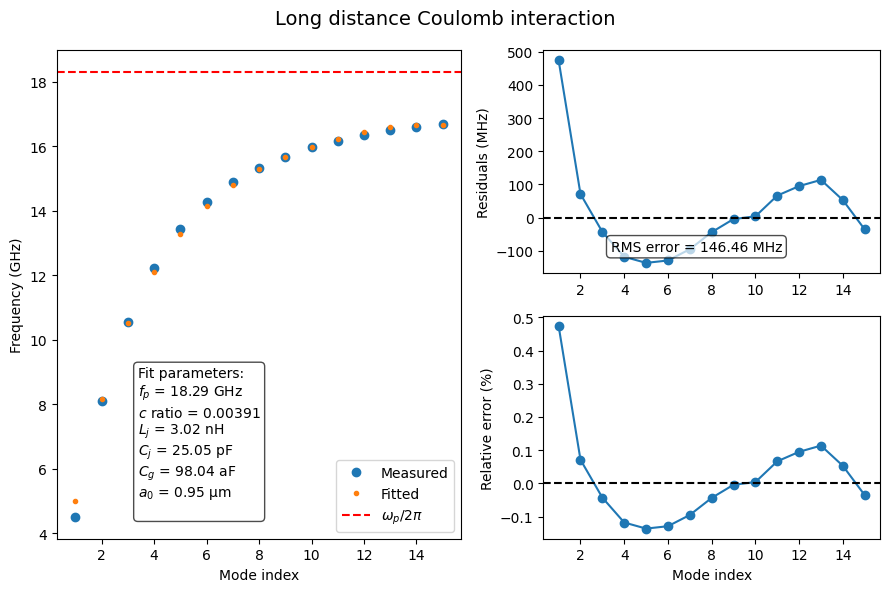

In [196]:
fig = plt.figure(figsize=(9, 6))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1.2, 1])
ax0 = fig.add_subplot(gs[:, 0])

ax0.plot(mode_indices, measured_frequencies, "o", label="Measured")
ax0.plot(
    mode_indices,
    fitted_jja.resonance_frequencies()[: len(measured_frequencies)],
    ".",
    label="Fitted",
)
ax0.axhline(
    fitted_jja.plasma_frequency, color="red", linestyle="--", label=r"$\omega_p/2\pi$"
)
ax0.set_ylabel("Frequency (GHz)")
ax0.set_xlabel("Mode index")
ax0.legend()
# Add text with fit parameters
Lj = fitted_jja.Lj * 1e9
Cj = fitted_jja.Cj * 1e15
Cg = fitted_jja.Cg * 1e18
a0 = fitted_jja.extra_params["a0"] * 1e6  # Convert to fF
# f_p_err = results['uncertainties']['f_p']
# c_ratio_err = results['uncertainties']['c_ratio']
param_text = (
    f"Fit parameters:\n"
    f"$f_p$ = {fitted_jja.plasma_frequency:.2f} GHz\n"
    f"$c$ ratio = {fitted_jja.C_ratio:.5f}\n"
    f"$L_j$ = {Lj:.2f} nH\n"
    f"$C_j$ = {Cj:.2f} pF\n"
    f"$C_g$ = {Cg:.2f} aF\n"
    f"$a_0$ = {a0:.2f} µm\n"
)
ax0.text(
    0.2,
    0.05,
    param_text,
    transform=ax0.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

# Top right plot
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(mode_indices, results["residuals"] * 1e3, "o-")
ax1.set_ylabel("Residuals (MHz)")
ax1.axhline(0, color="black", linestyle="--")

# Bottom right plot
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax2.plot(mode_indices, results["residuals"], "o-")
ax2.set_ylabel("Relative error (%)")
ax2.set_xlabel("Mode index")
ax2.axhline(0, color="black", linestyle="--")

# Add RMS error info
rms_error = results["errors"]["rmse"] * 1e3
error_text = f"RMS error = {rms_error:.2f} MHz"
ax1.text(
    0.2,
    0.1,
    error_text,
    transform=ax1.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

fig.suptitle("Long distance Coulomb interaction", fontsize=14)
fig.tight_layout()
plt.show()

## 2.4. Long distance Coulomb interaction + $C_{in}$

In [197]:
def C_matrix_long_distance_with_Cin(jja: nJJA) -> np.ndarray:
    Cj = jja.Cj
    diagonals = [
        (-Cj) * np.ones(N - 2),
        (2 * Cj) * np.ones(N - 1),
        (-Cj) * np.ones(N - 2),
    ]
    C = diags(diagonals, [-1, 0, 1]).toarray()

    a0 = jja.extra_params.get("a0", 0.645e-6)
    Cin = jja.extra_params.get("Cin", 0)
    C[0, 0] += Cin

    C_g_long_distance = compute_capacitance_matrix(
        N=jja.N, epsilon=11.6, a=0.645e-6, a0=a0, d=850e-6, max_terms=1000
    )

    C += C_g_long_distance
    return C


def build_extra_params(p_extra: list[float]) -> dict[str, float]:
    return {
        "a0": p_extra[0] * 1e-6,  # µm → m
        "Cin": p_extra[1] * 1e-15,  # fF → F
    }

In [198]:
initial_params = [2, 42.0, 98.0, 0.6, 15]  # Lj, Cj, Cg, a0, Cin
bounds = ([1, 10.0, 0.0, 0, 0], [5.0, 50.0, 200.0, 2, 50.0])

fitted_jja, results = nJJA.fit_from_measurements(
    measured_frequencies=measured_frequencies,
    N=251,
    build_C_matrix_fn=C_matrix_long_distance_with_Cin,
    build_L_inv_matrix_fn=default_L_inv_matrix,
    initial_params=initial_params,
    bounds=bounds,
    relative_error=False,
    verbose=True,
    extra_param_names=["a0, Cin"],
    build_extra_params_fn=build_extra_params,
)

Fit summary:
Parameters: [ 3.0707721  23.62397455 30.78550426  0.99036391  9.25092006]
Cost: 0.12341965471078886
Message: `ftol` termination condition is satisfied.


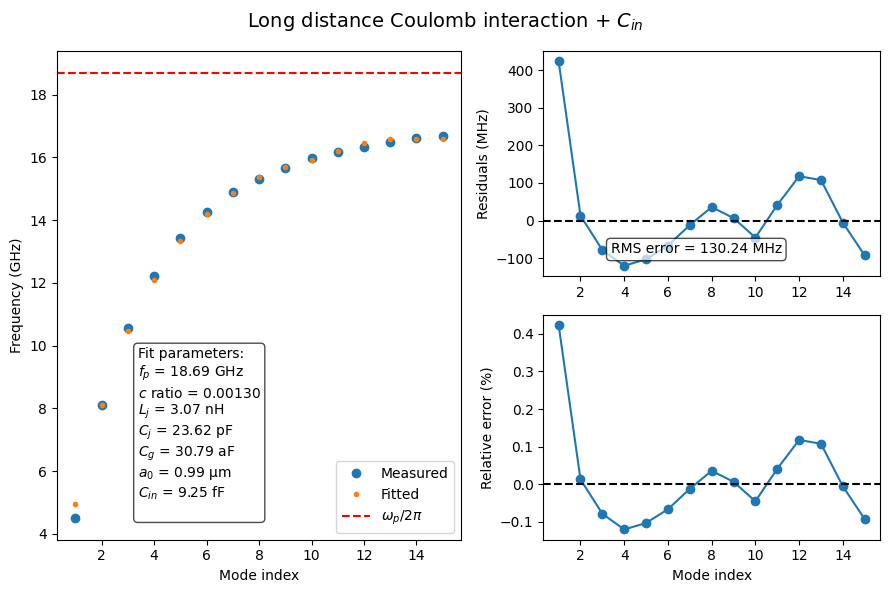

In [199]:
fig = plt.figure(figsize=(9, 6))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1.2, 1])
ax0 = fig.add_subplot(gs[:, 0])

ax0.plot(mode_indices, measured_frequencies, "o", label="Measured")
ax0.plot(
    mode_indices,
    fitted_jja.resonance_frequencies()[: len(measured_frequencies)],
    ".",
    label="Fitted",
)
ax0.axhline(
    fitted_jja.plasma_frequency, color="red", linestyle="--", label=r"$\omega_p/2\pi$"
)
ax0.set_ylabel("Frequency (GHz)")
ax0.set_xlabel("Mode index")
ax0.legend()
# Add text with fit parameters
Lj = fitted_jja.Lj * 1e9
Cj = fitted_jja.Cj * 1e15
Cg = fitted_jja.Cg * 1e18
a0 = fitted_jja.extra_params["a0"] * 1e6  # Convert to fF
Cin = fitted_jja.extra_params["Cin"] * 1e15  # Convert to fF

param_text = (
    f"Fit parameters:\n"
    f"$f_p$ = {fitted_jja.plasma_frequency:.2f} GHz\n"
    f"$c$ ratio = {fitted_jja.C_ratio:.5f}\n"
    f"$L_j$ = {Lj:.2f} nH\n"
    f"$C_j$ = {Cj:.2f} pF\n"
    f"$C_g$ = {Cg:.2f} aF\n"
    f"$a_0$ = {a0:.2f} µm\n"
    f"$C_{{in}}$ = {Cin:.2f} fF\n"
)
ax0.text(
    0.2,
    0.05,
    param_text,
    transform=ax0.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

# Top right plot
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(mode_indices, results["residuals"] * 1e3, "o-")
ax1.set_ylabel("Residuals (MHz)")
ax1.axhline(0, color="black", linestyle="--")

# Bottom right plot
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax2.plot(mode_indices, results["residuals"], "o-")
ax2.set_ylabel("Relative error (%)")
ax2.set_xlabel("Mode index")
ax2.axhline(0, color="black", linestyle="--")

# Add RMS error info
rms_error = results["errors"]["rmse"] * 1e3
error_text = f"RMS error = {rms_error:.2f} MHz"
ax1.text(
    0.2,
    0.1,
    error_text,
    transform=ax1.transAxes,
    bbox={"facecolor": "white", "alpha": 0.7, "boxstyle": "round"},
)

fig.suptitle(r"Long distance Coulomb interaction + $C_{in}$", fontsize=14)
fig.tight_layout()
plt.show()